# Wine

## Required Packages

In [1]:
import random
import collections

import pandas as pd
import numpy as np
import seaborn as sns
import nltk

seed = 42
random.seed(seed)
np.random.seed(42)

## Read and Split Data

In [2]:
# Read the data
df = pd.read_csv('./data/winemag-data-130k-v2.csv')
print(f'Columns: {list(df.columns)}')
print(f'N Rows: {len(df.index)}')

# split it into train, dev, and test
# courtesy of https://stackoverflow.com/a/38251063
perm = np.random.permutation(df.index)
m = len(df.index)

train_percent = .6
dev_percent = .2

train_end = int(m * train_percent)
dev_end = int(m * dev_percent) + train_end

train_df = df.iloc[perm[:train_end]]
dev_df = df.iloc[perm[train_end:dev_end]]
test_df = df.iloc[perm[dev_end:]]

print(f'Train shape: {train_df.shape}')
print(f'Dev shape: {dev_df.shape}')
print(f'Test shape: {test_df.shape}')

Columns: ['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']
N Rows: 129971
Train shape: (77982, 14)
Dev shape: (25994, 14)
Test shape: (25995, 14)


## Initial Investigation
Let's start by just looking at the data and seeing what pops out to us. We'll spend a little time looking at the continuous values points and price, and then spend more time looking at the words

In [3]:
train_df.describe(include='all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,77982.000000,77943,77982,55330,77982.000000,72568.000000,77943,65329,30329,62232,59215,77982,77981,77982
unique,NaN,42,74320,27151,NaN,NaN,393,1146,17,19,15,73824,644,14410
top,NaN,US,This zesty red has pretty aromas that suggest ...,Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,NaN,32688,3,1247,NaN,NaN,21743,2670,6736,15417,15417,7,7942,140
mean,64948.374048,NaN,NaN,NaN,88.450155,35.465274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,37442.642506,NaN,NaN,NaN,3.046516,41.103730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,32697.250000,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,64754.000000,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,97368.000000,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Points

It appears that the points are located between 80-100. This matches up with the source of the data that claims they do not publish reviews for any wine scored less than 80. More information on wine scoring can be viewed [here](https://www.winespectator.com/articles/scoring-scale)

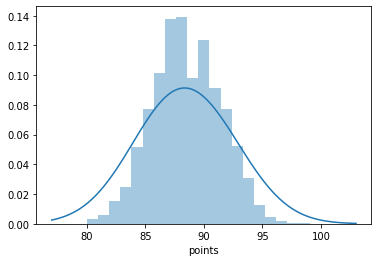

In [4]:
sns.distplot(train_df.points, bins=21, kde_kws={'bw':1})

So it looks like this is a textbook normal distribution with an incredibly slight left skew. Let's just make sure that every value is represented.

In [5]:
print(np.sort(train_df.points.unique()))

[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]


Any missing values?

In [6]:
train_df.points.isna().sum()

0

### Price

Since this is related to currency, I bet my lunch this is a heavy tailed distribution. Let's see.

Missing values: 5414


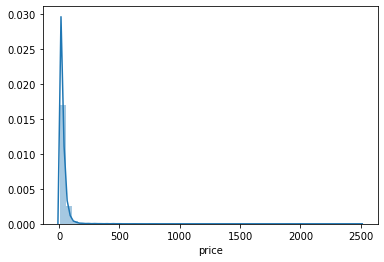

In [7]:
print(f'Missing values: {train_df.price.isna().sum()}')

# let's remove the missing prices for now
sns.distplot(train_df[~train_df.price.isna()].price)

Nice... lets log scale this.

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


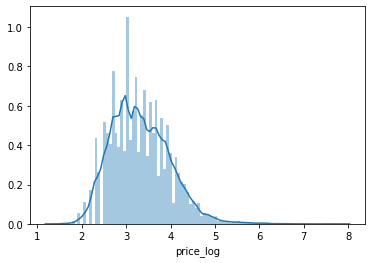

In [8]:
train_df['price_log'] = np.log(train_df.price)
ax = sns.distplot(train_df[~train_df.price_log.isna()].price_log, bins=100)

Just out of curiosity, I see that the lowest price is 4 dollars... what's the score on those?

In [9]:
train_df[train_df.price == 4].points.mean()

84.2

### Non-Continuous Stuff

In [10]:
non_cont_columns = train_df.columns[train_df.dtypes == np.object]
print(f'Non-Continuous columns: {list(non_cont_columns)}')

Non-Continuous columns: ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


Let's start by focusing on the descriptions. We'll tokenize, canonize, construct a vocabulary, and finally get counts for each of the items.

In [11]:
counter = collections.Counter()

for s in train_df.description:
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    counter.update(tokenized)

vocab = counter.items()
print(len(vocab))

36549


In [12]:
# view most common words 
most_common = counter.most_common(25)
print(most_common)

[(',', 263906), ('.', 211815), ('and', 208570), ('the', 132532), ('a', 107459), ('of', 103735), ('with', 72428), ('this', 68444), ('is', 58357), ('it', 51575), ('wine', 48002), ('flavors', 37378), ('in', 37299), ('to', 33333), ("'s", 30781), ('on', 27408), ('fruit', 26915), ('that', 24104), ('aromas', 23667), ('palate', 22850), ('acidity', 21095), ('finish', 20846), ('from', 19509), ('but', 18574), ('tannins', 18493)]


One very interesting thing viewed here is that in the most common words are very wine specific words. This is pretty obvious in hindsight, but it made me laugh to see wine just outside of the top 10.

Now let's look at the tasters. We'll see how many there are, and the distribution of the number of reviews each has given

19 Tasters: ['Joe Czerwinski', 'Roger Voss', 'Michael Schachner', 'Jim Gordon', 'Paul Gregutt', 'Kerin O’Keefe', 'Matt Kettmann', 'Anna Lee C. Iijima', 'Sean P. Sullivan', 'Lauren Buzzeo', 'Virginie Boone', 'Mike DeSimone', 'Anne Krebiehl\xa0MW', 'Carrie Dykes', 'Susan Kostrzewa', 'Jeff Jenssen', 'Alexander Peartree', 'Fiona Adams', 'Christina Pickard']


/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


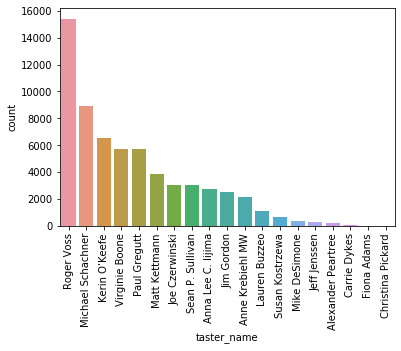

In [13]:
tasters = train_df.taster_name.dropna().unique()
print(f'{len(tasters)} Tasters: {list(tasters)}')
train_df.taster_name = train_df.taster_name.astype('category')

taster_counts  = train_df.taster_name.value_counts()
ax = sns.countplot(train_df.taster_name, order=taster_counts.index)
_ = ax.set_xticklabels(taster_counts.index, rotation=90)

As expected, there appears to be a Zeta distribution in the contributions of each taster. Let's what the numbers are on the 3 least active contributors: Carrie Dykes, Fiona Adams, and Christina Pickard.

In [14]:
print(taster_counts[['Carrie Dykes', 'Fiona Adams', 'Christina Pickard']])

Carrie Dykes         79
Fiona Adams          19
Christina Pickard     4
Name: taster_name, dtype: int64


We'll need to keep this in mind for subsequent analysis since the data related to their contributions will likely not be as representative as someone on the center or left of the distribution

Just for funsies, let's look at the vocabulary of each individual taster

In [15]:
taster_vocabs = {n: collections.Counter() for n in tasters}

for _, row in train_df[~train_df.taster_name.isna()].iterrows():
    taster = row.taster_name
    s = row.description
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    taster_vocabs[taster].update(tokenized)

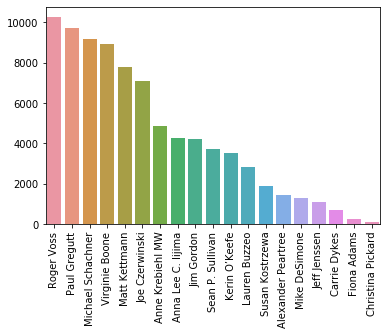

In [35]:
taster_vocab_lens = {k: len(v.items()) for k, v in taster_vocabs.items()}
taster_vocab_lens = pd.Series(taster_vocab_lens).sort_values().iloc[::-1]

ax = sns.barplot(x=taster_vocab_lens.index, y=taster_vocab_lens)
_ = ax.set_xticklabels(taster_vocab_lens.index, rotation=90)

As expected, Roger Voss is up top since he has had the most opportunity to use unique words. Let's compare the two lists.

In [50]:
compare_list = []

contribution_count_list = list(taster_counts.index)

print('Vocab Size compared to Contribution:')
for vocab_idx, taster in enumerate(taster_vocab_lens.index):
    count_idx = contribution_count_list.index(taster)
    diff = count_idx - vocab_idx
    print(f'\t{vocab_idx + 1}: {taster} ({diff:+d})')

Vocab Size compared to Contribution:
	1: Roger Voss (+0)
	2: Paul Gregutt (+3)
	3: Michael Schachner (-1)
	4: Virginie Boone (+0)
	5: Matt Kettmann (+1)
	6: Joe Czerwinski (+1)
	7: Anne Krebiehl MW (+4)
	8: Anna Lee C. Iijima (+1)
	9: Jim Gordon (+1)
	10: Sean P. Sullivan (-2)
	11: Kerin O’Keefe (-8)
	12: Lauren Buzzeo (+0)
	13: Susan Kostrzewa (+0)
	14: Alexander Peartree (+2)
	15: Mike DeSimone (-1)
	16: Jeff Jenssen (-1)
	17: Carrie Dykes (+0)
	18: Fiona Adams (+0)
	19: Christina Pickard (+0)


Kerin O'Keefe appears to be relatively bland in her word usage.